In [1]:
input_model = "bert"

In [2]:
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [3]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install pyyaml h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 57.1 MB/s eta 0:00:00


In [5]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig, TFRobertaForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig

from transformers import logging
logging.set_verbosity_error()

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score


import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [6]:
#@title Global tunable parameters

# Sequence length to truncate/pad
MAX_SEQUENCE_LENGTH = 512 #800

# hidden layer size after BERT's ouput
HIDDEN_LAYER_SIZE = 512

# Max embeddings in BERT
BERT_MAX_EMBEDDINGS = 512 #1024
ROBERTA_MAX_EMBEDDINGS = 512 #1024
DISTILBERT_MAX_EMBEDDINGS = 512 #1024

# fraction of data to use for training
FRACTION = 1

# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [7]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')
print_version('pandas')
print_version('sklearn')

numpy version: 1.26.4
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0
pandas version: 2.1.4
sklearn version: 1.3.2


In [8]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [9]:
rdt_trainfile = f'{BASE_PATH}/Reddit/titles_train.csv'
rdt_tesstfile = f'{BASE_PATH}/Reddit/titles_test.csv'
rdt_valfile = f'{BASE_PATH}/Reddit/titles_val.csv'

rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)
rdt_val = pd.read_csv(rdt_valfile)

In [10]:
rdt_train

,ID,title,class_name,class_id
0,691324c4-5c30-44e0-b9e4-45b4f0715e21,a question about the third conditional.,none,5
1,d4295391-9ca5-4398-b7c8-687e4a984ef1,the epitome of my life,adhd,0
2,58937fa5-3c2c-426b-8255-5a140fbab675,what are your favourites offbeat destinations ...,none,5
3,7daf364c-3b33-4cbe-be37-a214edf9a73e,synesthesia survey (what colour is each month ...,none,5
4,22518271-4bb4-4caf-b683-7305da519288,"science ama series: i’m phil baran, and i’m he...",none,5
...,...,...,...,...
13722,386a4117-0324-4b25-8330-b1a6857ccaa6,trying to wake up and leave the house every mo...,bipolar,2
13723,4dd92d63-1231-410d-b049-5d8c430c2f36,"""hey man, what'd you do this past weekend?""",depression,3
13724,dbde1d3e-e527-4cf8-8045-2093aec2a784,"how to use "" whereby "" correctly?",none,5
13725,5355fad6-5bb4-4092-8428-9b8527a6d261,"i'm sorry, another depression post",bipolar,2


In [11]:
rdt_test

,ID,title,class_name,class_id
0,b07b978c-7760-4932-85cb-5797b5e74168,"basic needs for neurotypicals : food, clothing...",adhd,0
1,b2868fd2-e885-400e-b780-446c9581b1f1,"""you're just an iphone in an android world.: d...",adhd,0
2,3191b3b1-d355-41b6-9588-caeb3e169c9b,"""what kind of music do you listen to?"" no answer",adhd,0
3,a3d60895-ef7c-4b57-b5be-632c9fd62150,couldn’t help crying while reading a post that...,adhd,0
4,66fae18e-e744-495f-b7a0-b985543f5052,shout-out to all the parents with adhd childre...,adhd,0
...,...,...,...,...
1483,5855d35b-bf7d-4a49-8030-b185f430f05a,i went on a solo motorcycle ride from tamil na...,none,5
1484,a2faea38-8b93-43da-a75b-cb7c0ba1ae0d,hello and namaste to r/india... from r/nepal. ...,none,5
1485,7ad72b7f-eba4-4c17-90b0-1038dc144a8b,public api for the largest video game database...,none,5
1486,e73c198f-5e8e-4c84-aedf-333b576f9939,acs ama: hi reddit! my name is dr. john m news...,none,5


In [12]:
rdt_val

,ID,title,class_name,class_id
0,34db02f0-82ed-43e9-ac8b-65db8ba55a95,do others feel like they have a warped sense o...,adhd,0
1,f515fc3a-0f62-4203-bfc8-53a8252a8fc1,do you ever feel like one small failure can de...,adhd,0
2,93ed44ff-20b8-4bc2-b71b-6c7a39fa4775,so you've heard about getting a song in your h...,adhd,0
3,e9ec2f5b-f709-40c4-b4f2-202ebbe5bc87,anyone here have listening comprehension probl...,adhd,0
4,2e6f28e3-acbe-44ac-82f0-a980aa07a464,i finally found a way to wake my ass up in the...,adhd,0
...,...,...,...,...
1483,55acf4ff-e555-4804-8a15-b3e9a27aecbc,psa: wear earplugs to concerts.,none,5
1484,b4821450-78a9-4fde-8da0-9e99a39a49db,as a cop that worked the may day protests (and...,none,5
1485,d0cea880-458c-41ad-a464-82183fca0bd5,how to increase your listening skills?,none,5
1486,7346a22c-4f59-459c-815b-f3c79e67a8fa,i'm in treatment for drugs and alcohol and wou...,none,5


In [15]:
#@title Read Reddit dataset into a dataframe
rdt_trainfile = f'{BASE_PATH}/Reddit/titles_train.csv'
rdt_tesstfile = f'{BASE_PATH}/Reddit/titles_test.csv'
rdt_valfile = f'{BASE_PATH}/Reddit/titles_val.csv'

rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)
rdt_val = pd.read_csv(rdt_valfile)

# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)
rdt_val = rdt_val.sample(frac=1).reset_index(drop=True)


# Split data into test and train
#train_size = int(0.8 * len(rdt_train))
train_size = int(len(rdt_train))
X_train = rdt_train.title
X_val = rdt_val.title
X_test = rdt_test.title
y_train = rdt_train.class_id
y_val = rdt_val.class_id
y_test = rdt_test.class_id

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(y_val)

train_examples_list = []
test_examples_list = []
val_examples_list = []

temp_train_examples = np.array(X_train)
temp_test_examples = np.array(X_test)
temp_val_examples = np.array(X_val)

for i in range(len(temp_train_examples)):
  size = len(temp_train_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    train_examples_list.append(temp_train_examples[i][:lower] + temp_train_examples[i][upper:])
  else:
    train_examples_list.append(temp_train_examples[i])

for i in range(len(temp_test_examples)):
  size = len(temp_test_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    test_examples_list.append(temp_test_examples[i][:lower] + temp_test_examples[i][upper:])
  else:
    test_examples_list.append(temp_test_examples[i])

for i in range(len(temp_val_examples)):
  size = len(temp_val_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    val_examples_list.append(temp_val_examples[i][:lower] + temp_val_examples[i][upper:])
  else:
    val_examples_list.append(temp_val_examples[i])

train_examples = np.array(train_examples_list)
test_examples = np.array(test_examples_list)
val_examples = np.array(val_examples_list)


In [16]:
print(rdt_train.class_name.unique())
rdt_train.class_id.unique()

['adhd' 'anxiety' 'none' 'ptsd' 'bipolar' 'depression']


array([0, 1, 5, 4, 2, 3])

In [17]:
print(rdt_test.class_name.unique())
rdt_test.class_id.unique()

['depression' 'adhd' 'none' 'bipolar' 'ptsd' 'anxiety']


array([3, 0, 5, 2, 4, 1])

In [18]:
print(rdt_val.class_name.unique())
rdt_val.class_id.unique()

['depression' 'none' 'anxiety' 'ptsd' 'bipolar' 'adhd']


array([3, 5, 1, 4, 2, 0])

In [19]:
rdt_train

,ID,title,class_name,class_id
0,0cbd5330-49d2-49a9-adad-2c4ecd153285,add shower thought: waiting for a reply to you...,adhd,0
1,5715f4f9-c21e-467c-8e5f-b0a48cc1c114,does anyone else get anxiety about breathing h...,anxiety,1
2,6fd9b95d-50c5-4d1d-b1c9-3f67c4e7477d,megathread: michael cohen to assert 5th amendm...,none,5
3,e5b71745-137e-40eb-a42a-12154423afdc,sometimes it really sucks to realize all of th...,ptsd,4
4,bc9e1b4f-a653-40e4-bb24-f44dc8f5415f,"after 2 years of unemployment, i've gotten a j...",bipolar,2
...,...,...,...,...
13722,ef45c031-3699-4d45-adb1-8e59513059f2,i went to a bookstore and got a coffee by myse...,anxiety,1
13723,a8322429-0e6c-46fe-80f5-04cc6745758b,i washed a pot,bipolar,2
13724,ce42db01-4cfd-414f-b25c-3b6f10e555a5,i feel like i’m a huge burden on my poor husband,bipolar,2
13725,4a771c34-0539-4c9c-9c5c-2a40a965d661,5 tips to create a more reliable crawler,none,5


In [20]:
test_examples[30]

'technique for calming yourself down.'

In [21]:
test_labels[30]

1

In [22]:
val_examples[30]

'if i ever win the lottery...'

In [23]:
val_labels[30]

3

In [25]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

# print('Distribution of the length of all posts')
# print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (13727,)
Validation set labels shape: (1488,)
Test set labels shape: (1488,)
Training set examples shape: (13727,)
Validation set examples shape: (1488,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Labels min : 0 max : 5


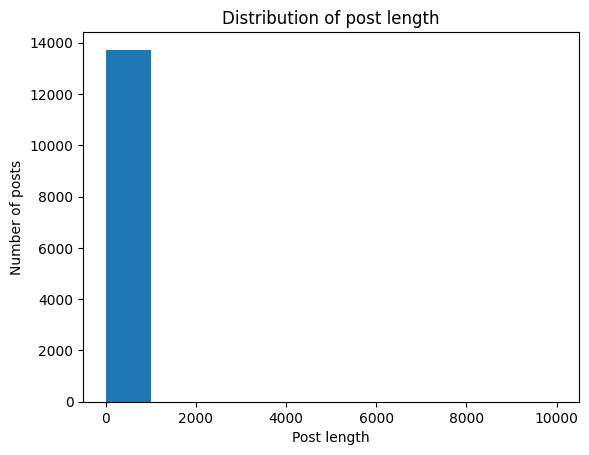

In [27]:
#@ Histogram of all title length
plt.hist(rdt_train["title"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of post length')
plt.xlabel('Post length')
plt.ylabel('Number of posts')
plt.show()

In [28]:
rdt_train

,ID,title,class_name,class_id
0,0cbd5330-49d2-49a9-adad-2c4ecd153285,add shower thought: waiting for a reply to you...,adhd,0
1,5715f4f9-c21e-467c-8e5f-b0a48cc1c114,does anyone else get anxiety about breathing h...,anxiety,1
2,6fd9b95d-50c5-4d1d-b1c9-3f67c4e7477d,megathread: michael cohen to assert 5th amendm...,none,5
3,e5b71745-137e-40eb-a42a-12154423afdc,sometimes it really sucks to realize all of th...,ptsd,4
4,bc9e1b4f-a653-40e4-bb24-f44dc8f5415f,"after 2 years of unemployment, i've gotten a j...",bipolar,2
...,...,...,...,...
13722,ef45c031-3699-4d45-adb1-8e59513059f2,i went to a bookstore and got a coffee by myse...,anxiety,1
13723,a8322429-0e6c-46fe-80f5-04cc6745758b,i washed a pot,bipolar,2
13724,ce42db01-4cfd-414f-b25c-3b6f10e555a5,i feel like i’m a huge burden on my poor husband,bipolar,2
13725,4a771c34-0539-4c9c-9c5c-2a40a965d661,5 tips to create a more reliable crawler,none,5


In [29]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 2465/13727 (0.17957310410140598)
Labels 1 in training set: 2422/13727 (0.17644059153493116)
Labels 2 in training set: 2407/13727 (0.17534785459313762)
Labels 3 in training set: 2450/13727 (0.17848036715961244)
Labels 4 in training set: 2001/13727 (0.14577110803525897)
Labels 0 in validation set: 248/1488 (0.16666666666666666)
Labels 1 in validation set: 248/1488 (0.16666666666666666)
Labels 2 in validation set: 248/1488 (0.16666666666666666)
Labels 3 in validation set: 248/1488 (0.16666666666666666)
Labels 4 in validation set: 248/1488 (0.16666666666666666)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [30]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

print(mh_dict_id_to_name)
print(mh_dict_name_to_id)


{0: 'adhd', 1: 'anxiety', 5: 'none', 4: 'ptsd', 2: 'bipolar', 3: 'depression'}
{'adhd': 0, 'anxiety': 1, 'none': 5, 'ptsd': 4, 'bipolar': 2, 'depression': 3}


In [31]:
#@title BERT Tokenization of training, validation and test data

def tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    bert_train_tokenized = tokenize_data(tokenizer, train_examples_str)
    bert_val_tokenized = tokenize_data(tokenizer, val_examples_str)

    bert_train_inputs = [bert_train_tokenized.input_ids,
                        bert_train_tokenized.token_type_ids,
                        bert_train_tokenized.attention_mask]


    bert_val_inputs = [bert_val_tokenized.input_ids,
                        bert_val_tokenized.token_type_ids,
                        bert_val_tokenized.attention_mask]


    return bert_train_inputs, bert_val_inputs

In [32]:
def tokenize_data(tokenizer, input_str):
  tokenized = tokenizer(input_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
  return tokenized

In [33]:
#@title BERT Tokenization of training, validation and test data

def tokenize_test(tokenizer, test_examples):

    test_examples_str = [x for x in test_examples]

    # Tokenize training, validation and test data
    bert_test_tokenized = tokenize_data(tokenizer, test_examples_str)

    bert_test_inputs = [bert_test_tokenized.input_ids,
                        bert_test_tokenized.token_type_ids,
                        bert_test_tokenized.attention_mask]


    return bert_test_inputs

In [34]:

#@title Train BERT model using CLS token
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    #bert_out = bert_base_model(bert_inputs)
    bert_out = bert_base_model.bert([input_ids, attention_mask, token_type_ids])


    # The first token of every example is a CLS token
    cls_embedding = bert_out[0][:, 0, :]
    print(cls_embedding.shape)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_embedding)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(6, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


def bert_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train BERT model
    """
    # Load BERT model
    config_l = BertConfig.from_pretrained("bert-base-cased")
    config_l.num_max_position_embeddingslabels = BERT_MAX_EMBEDDINGS
    bert_model = TFBertModel.from_pretrained('bert-base-cased', config = config_l)

    # Load training, validation and test data
    train_samples = train[0:int(fraction*len(train))]
    val_samples = val[0:int(fraction*len(val))]

    # Tokenize training, validation and test data
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    bert_train_inputs, bert_val_inputs = tokenize_train_val(bert_tokenizer, train_samples, val_samples)

    # Convert labels to numpy arrays
    bert_train_labels = np.array(tlabels)
    bert_train_sample_labels = bert_train_labels[0:int(fraction*len(tlabels))]

    bert_val_labels = np.array(vlabels)
    bert_val_sample_labels = bert_val_labels[0:int(fraction*len(vlabels))]

    # Create classification model
    bert_avg_model = create_bert_cls_model(bert_model, hidden_size=HIDDEN_LAYER_SIZE)

    bert_avg_model.summary()

    bert_avg_model_history = bert_avg_model.fit(
        bert_train_inputs,
        bert_train_sample_labels,
        validation_data=(bert_val_inputs, bert_val_sample_labels),
        batch_size=12,
        epochs=2)

    return bert_avg_model, bert_avg_model_history

In [35]:
fraction = 1
model, model_history = bert_main(train_examples, val_examples, train_labels, val_labels, fraction)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

(None, 768)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_layer (InputLaye  [(None, 800)]                0         []                            
 r)                                                                                               
                                                                                                  
 attention_mask_layer (Inpu  [(None, 800)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 800)]                0         []                            
 tLayer)                                                                          

1144/1144 [==============================] - 670s 551ms/step - loss: 1.0385 - accuracy: 0.6075 - val_loss: 0.8725 - val_accuracy: 0.6767
Epoch 2/2
1144/1144 [==============================] - 628s 549ms/step - loss: 0.7268 - accuracy: 0.7373 - val_loss: 0.8892 - val_accuracy: 0.6781


In [36]:
# Save the model
path = f'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/saved_models/{input_model}_titles'
if not os.path.exists(path):
  os.makedirs(path, exist_ok=True)
print(f'Saving model to {path}')
tf.keras.models.save_model(model, path)

Saving model to drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/saved_models/bert_titles


In [37]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
test_tokens = tokenize_test(bert_tokenizer, test_examples)
y_prediction = model.predict(test_tokens)

47/47 [==============================] - 23s 431ms/step


In [38]:
y_prediction

array([[5.9057649e-02, 2.1571442e-01, 1.0237499e-01, 5.8904558e-01,
        3.0941125e-02, 2.8662242e-03],
       [9.9985373e-01, 1.7208462e-05, 9.2803515e-05, 5.0166091e-06,
        2.8466357e-05, 2.7711219e-06],
       [1.4809069e-03, 5.6174081e-03, 2.1235870e-02, 9.6979618e-01,
        1.7251518e-03, 1.4455350e-04],
       ...,
       [3.0726839e-02, 1.0470247e-01, 2.3868006e-01, 9.6975006e-02,
        5.2067083e-01, 8.2448069e-03],
       [8.3718644e-03, 2.5950091e-02, 2.6714440e-02, 9.2961079e-01,
        8.8397274e-03, 5.1310303e-04],
       [3.4385838e-02, 1.4828049e-01, 4.9341522e-02, 7.3615265e-01,
        3.0531427e-02, 1.3080232e-03]], dtype=float32)

In [39]:
# Convert predicted probabilities to class labels
y_pred_label = np.argmax(y_prediction, axis=1) # Convert probabilities to discrete class labels

In [40]:
y_pred_label

array([3, 0, 3, ..., 4, 3, 3])

	 Printing confusion matrix


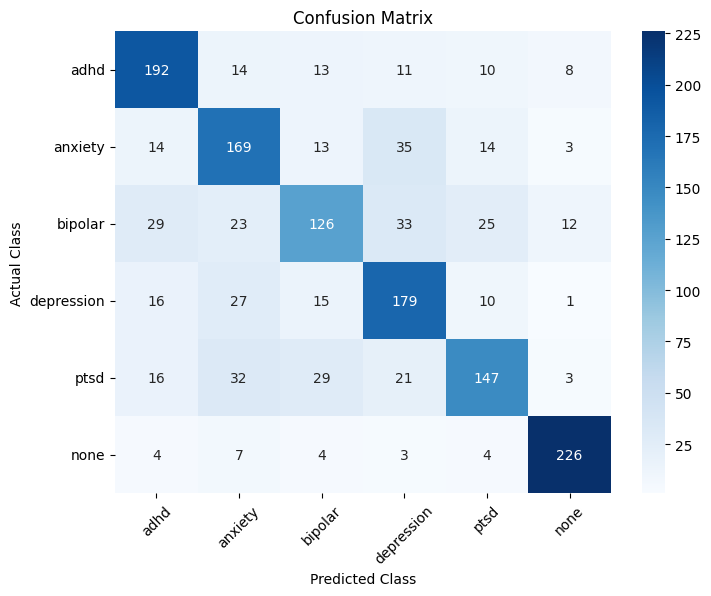

Accuracy: 0.698252688172043
              precision    recall  f1-score   support

        adhd       0.71      0.77      0.74       248
     anxiety       0.62      0.68      0.65       248
     bipolar       0.63      0.51      0.56       248
  depression       0.63      0.72      0.68       248
        ptsd       0.70      0.59      0.64       248
        none       0.89      0.91      0.90       248

    accuracy                           0.70      1488
   macro avg       0.70      0.70      0.70      1488
weighted avg       0.70      0.70      0.70      1488



In [41]:
from sklearn.metrics import confusion_matrix
print('\t Printing confusion matrix')
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(test_labels, y_pred_label)

# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

# Add string labels to the axes
plt.xticks(ticks=np.arange(len(actuals_names)) + 0.5, labels=actuals_names, rotation=45)
plt.yticks(ticks=np.arange(len(predictions_names)) + 0.5, labels=predictions_names, rotation=0)

# Add labels, title, and color bar
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, y_pred_label)}')

print(classification_report(test_labels, y_pred_label, target_names=predictions_names))

In [43]:
print('\t Saving all mismatches')
# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

mismatches = []
for i in range(len(test_labels)):
    if test_labels[i] != y_pred_label[i]:
        id1 = test_labels[i]
        id2 = y_pred_label[i]
        entry = {}
        entry['actual'] = actuals_names[id1]
        entry['predicted'] = predictions_names[id2]
        entry['test_id'] = i
        entry['text'] = test_examples[i]
        mismatches.append(entry)
df = pd.DataFrame(mismatches)
df.to_csv('drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/mismatches_bert_titles.csv', index=False)


	 Saving all mismatches
